In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import os
from subprocess import Popen, PIPE
from scipy.stats import circmean, circstd
from time import sleep
from scipy.misc import imresize

In [2]:
dots_bin = '../../examples/97_detect_dots/97_detect_dots'

In [3]:
def circmedian(angs, high = 2 * np.pi):
    """ Calculate circular median """
    angs = np.array(angs) / high * (2 * np.pi)
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + np.pi) % (2 * np.pi) - np.pi
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [4]:
def angle_dist(a1, a2, high = 360):
    a1 *= 360 / high
    a2 *= 360 / high
    v1 = np.abs(a1 - a2)
    v2 = np.abs(360 - v1)
    return np.min([v1, v2], axis = 0) * high / 360

In [5]:
def get_mask(hsv, hmean = 0, hdelta = 10, smin = 100, smax = 255, vmin = 50, vmax = 255):

    # obtaining hsv channels
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    
    # doing thresholding
    h_mask = angle_dist(h, hmean, high = 180) <= hdelta
    s_mask = (s >= smin) & (s <= smax)
    v_mask = (v >= vmin) & (v <= vmax)
    mask = h_mask & s_mask & v_mask
    return mask

In [6]:
def get_dots_on_image(mask):
    """ Detect and return dots on the mask """
    
    # output temporary filename
    out_fn = '/tmp/tmpimgcvdots.png'
    
    # writing binarized image
    cv2.imwrite(out_fn, 1. * mask)
    
    def get_dots(in_fn):
        """ Run the 97_detect_dots project and output the detected dots """

        global bin_proc

        # run the executable (if not running)
        if not bin_proc:
            bin_proc = Popen([dots_bin], stdin=PIPE, stdout=PIPE)

        # writing data to the process
        bin_proc.stdin.write(in_fn + '\n')

        # obtaining the number of lines...
        n = int(bin_proc.stdout.readline().splitlines()[0])
        res = []
        for i in range(n):
            line = bin_proc.stdout.readline()
            line = line.splitlines()[0]
            line = [float(x) for x in line.split()]
            res += [line]

        # return the array with dots
        return res
    return get_dots(out_fn)

In [85]:
offsets = []
for i in range(-2, 3):
    for j in range(-2, 3):
        if abs(i) + abs(j) <= 2:
            offsets += [(i, j)]

In [86]:
def get_stats(hsv, mask, do_plot = False):
    
    # obtaining the list of points
    data = get_dots_on_image(mask)
    
    # obtaining HSV data for detected points
    hsv_points = []
    for point in data:
        point_ = [int(t) for t in point]
        for offset in offsets:
            point = hsv[point_[1] + offset[0], point_[0] + offset[1], :]
            if point[0] < 20 or point[0] >= 160:
                hsv_points += [list(point)]
            
    if len(hsv_points) == 0:
        return None, None, None
            
    hsv_points = 1. * np.array(hsv_points)
    
    if do_plot:
        plot_hsv(hsv_points)
    
    stats = [None] * 3
    stats[0] = (circmean(hsv_points[:, 0], high = 180), circstd(hsv_points[:, 0], high = 180), circmedian(hsv_points[:, 0], high = 180))
    stats[1] = (np.mean(hsv_points[:, 1]), np.std(hsv_points[:, 1]), np.median(hsv_points[:, 1]))
    stats[2] = (np.mean(hsv_points[:, 2]), np.std(hsv_points[:, 2]), np.median(hsv_points[:, 2]))
    
    return data, stats, hsv_points

In [118]:
def plot_hsv(hsv_points):
    fig = plt.figure()
    plt.title('HSV for dots')
    plt.xlabel('H, S, V')
    plt.ylabel('Frequency')
    plt.hist(hsv_points[:, 0], label = 'H', alpha = 0.5)
    plt.hist(hsv_points[:, 1], label = 'S', alpha = 0.5)
    plt.hist(hsv_points[:, 2], label = 'V', alpha = 0.5)
    plt.legend()
    return fig

In [119]:
def stats_to_params(stats, hsigma = 1, ssigma = 1, vsigma = 1):
    res = {}
    if not stats:
        res['hmean'] = res['hdelta'] = 0
        res['smin'] = res['smax'] = 0
        res['vmin'] = res['vmax'] = 0
        return res
    res['hmean'] = stats[0][2]
    res['hdelta'] = hsigma * stats[0][1]
    res['smin'] = stats[1][2] - ssigma * stats[1][1]
    res['smax'] = 255
    #res['smax'] = stats[1][2] + ssigma * stats[1][1]
    res['vmin'] = stats[2][2] - vsigma * stats[2][1]
    #res['vmax'] = stats[2][2] + vsigma * stats[2][1]
    res['vmax'] = 255
    return res

In [120]:
def plot_params(params_arr, default_params):
    # plot H
    hmean = [x['hmean'] for x in params_arr]
    hdelta = [x['hdelta'] for x in params_arr]
    L = 10
    plt.figure()
    plt.title('Dots parameters')
    plt.plot([default_params['hmean']] * L + hmean, label = 'HMedian')
    plt.plot([default_params['hdelta']] * L + hdelta, label = 'HDelta')

    # plot S
    smin = [x['smin'] for x in params_arr]
    smax = [x['smax'] for x in params_arr]
    #plt.fill_between(range(len(smin)), smin, smax, alpha = 0.3, label = 'S')
    plt.plot([default_params['smin']] * L + smin, label = 'Smin')
    
    # plot V
    vmin = [x['vmin'] for x in params_arr]
    vmax = [x['vmax'] for x in params_arr]
    #plt.fill_between(range(len(vmin)), vmin, vmax, alpha = 0.3, label = 'V')
    plt.plot([default_params['vmin']] * L + vmin, label = 'Vmin')
    plt.legend()
    plt.show()

{'hmean': 0, 'vmin': 50, 'smax': 255, 'smin': 50, 'vmax': 255, 'hdelta': 50}


AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

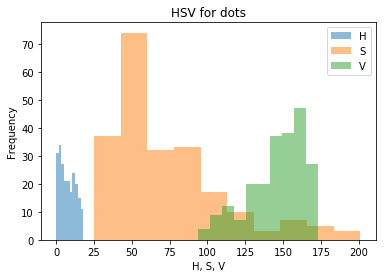

In [121]:
bin_proc = None
cap = cv2.VideoCapture('/home/sergei/Downloads/VID_20181125_194744.mp4')

# array of parameters
params_arr = []

# default parameters for the threshold
default_params = {'hmean': 0, 'hdelta': 50, 'vmin': 50,
                  'smin': 50, 'vmax': 255, 'smax': 255}
params = {x: y for x, y in default_params.items()}

while cap.isOpened():
    # reading frame
    ret, frame = cap.read()
    
    # breaking the loop if no frame available
    if not ret: break
    
    frame = imresize(frame, 0.2)
    
    # threshold
    #print(params)
    # obtaining HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # obtaining mask via thresholding
    print(params)
    mask = get_mask(hsv, **params)
    
    # obtain points
    data, stats, hsv_points = get_stats(hsv, mask)
    
    # plotting histogram
    fig = plot_hsv(hsv_points)
    
    if data:
        # obtaining plot data
        plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    
    # obtaining parameters for the next iteration
    new_params = stats_to_params(stats, hsigma = 1, ssigma = 1, vsigma = 3)
    
    mask = 1. * mask
    
    # if have detected the marker...
    if data:
        # drawing circles
        for point in data:
            cv2.circle(frame, tuple([int(t) for t in point]), 10, (255, 0, 0))
            cv2.circle(mask, tuple([int(t) for t in point]), 10, (255, 0, 0))

        # and updating the parameters
        #params['smin'] = new_params['smin']
        params['vmin'] = new_params['vmin']
    else:
        params = {x: y for x, y in default_params.items()}
        #break
    
    # adding current data
    params_arr += [new_params]
    
    cv2.imshow('frame', 1. * mask)
    cv2.imshow('frameOrig', frame)
    cv2.imshow('plot', plot)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        

cap.release()

In [ ]:
plot_params(params_arr, default_params)

In [48]:
np.mean([x['hmean'] != 0 for x in params_arr])

1.0

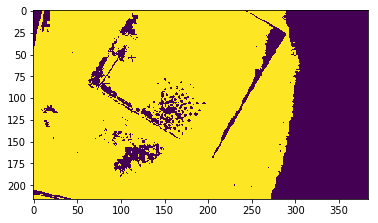

In [91]:
plt.imshow(mask, interpolation = 'none')

In [50]:
np.mean(mask)

0.95774257330246915

(array([ 241.,  177.,  235.,   89.,    0.,    0.,    0.,    0.,    0.,  233.]),
 array([   0. ,   10.2,   20.4,   30.6,   40.8,   51. ,   61.2,   71.4,
          81.6,   91.8,  102. ]),
 <a list of 10 Patch objects>)

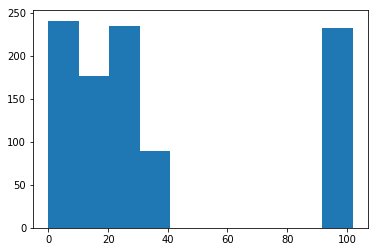

In [73]:
plt.hist(hsv_points[:, 0])

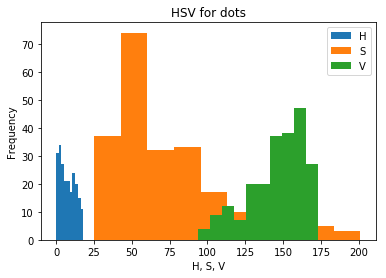

In [109]:
fig = plot_hsv(hsv_points)

In [105]:
cv2.imshow('frameOrig', frame)

In [106]:
data

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [ ]:
fig.canvas.tostring_rgb()